In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
from multihist import Histdd

import flamedisx as fd

import os

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


In [2]:
pdfs = [dict(), dict()]

## ROI for templates

In [3]:
xlzd_source = fd.xlzd.XLZDERSource(configuration='60t')

cS1_min = xlzd_source.cS1_min
cS1_max = xlzd_source.cS1_max
log10_cS2_min = xlzd_source.log10_cS2_min
log10_cS2_max = xlzd_source.log10_cS2_max

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


## Detector parameters

In [4]:
conditions = 'good'
drift_field_V_cm = 80.
gas_field_kV_cm = 7.5
elife_ns = 10000e3
g1 = 0.27

# conditions = 'bad'
# drift_field_V_cm = 25.
# gas_field_kV_cm = 6.
# elife_ns = 10000e3
# g1 = 0.27

## Background sources

In [5]:
SolarER = fd.xlzd.XLZDvERSource(configuration='60t',
                                drift_field_V_cm=drift_field_V_cm, gas_field_kV_cm=gas_field_kV_cm,
                                elife_ns=elife_ns, g1=g1)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


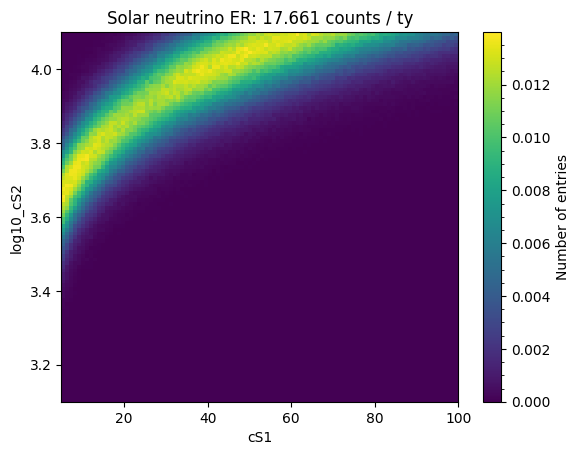

In [6]:
SolarER_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

SolarER_data = SolarER.simulate(int(1e7))

SolarER_hist.add(SolarER_data['cs1'], np.log10(SolarER_data['cs2']))

SolarER_mu = SolarER.estimate_mu(n_trials=int(1e7))
SolarER_hist.histogram = SolarER_hist.histogram / SolarER_hist.n * SolarER_mu

SolarER_hist.plot()
plt.title(f'Solar neutrino ER: {SolarER_mu:.3f} counts / ty')

pdfs[0]['SolarER'] = SolarER_hist

In [7]:
Pb214 = fd.xlzd.XLZDPb214Source(configuration='60t',
                                drift_field_V_cm=drift_field_V_cm, gas_field_kV_cm=gas_field_kV_cm,
                                elife_ns=elife_ns, g1=g1)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


Text(0.5, 1.0, 'Pb214: 2.481 counts / ty')

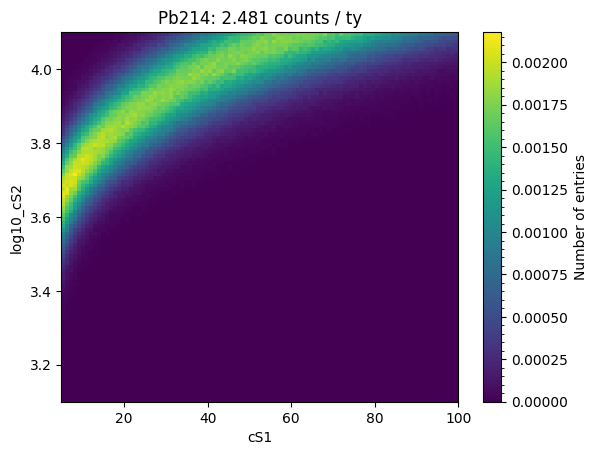

In [8]:
Pb214_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

Pb214_data = Pb214.simulate(int(1e7))

Pb214_hist.add(Pb214_data['cs1'], np.log10(Pb214_data['cs2']))

Pb214_mu = Pb214.estimate_mu(n_trials=int(1e7))
Pb214_hist.histogram = Pb214_hist.histogram / Pb214_hist.n * Pb214_mu

Pb214_hist.plot()
plt.title(f'Pb214: {Pb214_mu:.3f} counts / ty')

In [9]:
if (conditions == 'good'):
    pdfs[0]['Pb214_high_LNGS'] = Pb214_hist * (0.61 / 0.1)
    pdfs[0]['Pb214_low_LNGS'] = Pb214_hist * (0.061 / 0.1)
    pdfs[0]['Pb214_high_SURF'] = Pb214_hist * (0.8 / 0.1)
    pdfs[0]['Pb214_low_SURF'] = Pb214_hist * (0.08 / 0.1)
elif (conditions == 'bad'):
    pdfs[0]['Pb214_high_LNGS'] = Pb214_hist * (0.079 / 0.1)
    pdfs[0]['Pb214_low_LNGS'] = Pb214_hist * (0.0079 / 0.1)
    pdfs[0]['Pb214_high_SURF'] = Pb214_hist * (0.1 / 0.1)
    pdfs[0]['Pb214_low_SURF'] = Pb214_hist * (0.01 / 0.1)

In [10]:
Kr85 = fd.xlzd.XLZDKr85Source(configuration='60t',
                              drift_field_V_cm=drift_field_V_cm, gas_field_kV_cm=gas_field_kV_cm,
                              elife_ns=elife_ns, g1=g1)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


Text(0.5, 1.0, 'Kr85: 10.217 counts / ty')

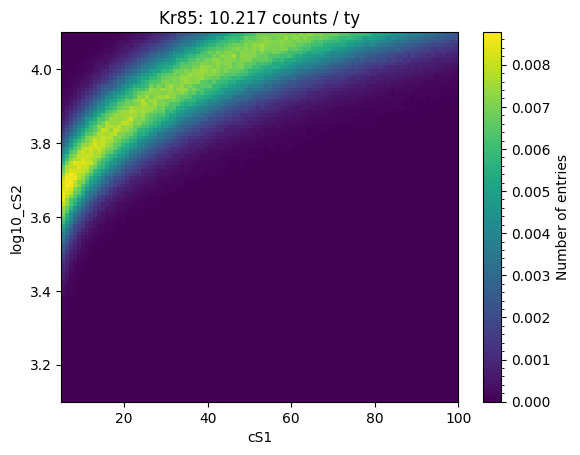

In [11]:
Kr85_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

Kr85_data = Kr85.simulate(int(1e7))

Kr85_hist.add(Kr85_data['cs1'], np.log10(Kr85_data['cs2']))

Kr85_mu = Kr85.estimate_mu(n_trials=int(1e7))
Kr85_hist.histogram = Kr85_hist.histogram / Kr85_hist.n * Kr85_mu

Kr85_hist.plot()
plt.title(f'Kr85: {Kr85_mu:.3f} counts / ty')

In [12]:
if (conditions == 'good'):
    pdfs[0]['Kr85_high_LNGS'] = Kr85_hist * (0.15 / 0.1)
    pdfs[0]['Kr85_low_LNGS'] = Kr85_hist * (0.015 / 0.1)
    pdfs[0]['Kr85_high_SURF'] = Kr85_hist * (0.2 / 0.1)
    pdfs[0]['Kr85_low_SURF'] = Kr85_hist * (0.02 / 0.1)
elif (conditions == 'bad'):
    pdfs[0]['Kr85_high_LNGS'] = Kr85_hist * (0.019 / 0.1)
    pdfs[0]['Kr85_low_LNGS'] = Kr85_hist * (0.0019 / 0.1)
    pdfs[0]['Kr85_high_SURF'] = Kr85_hist * (0.025 / 0.1)
    pdfs[0]['Kr85_low_SURF'] = Kr85_hist * (0.0025 / 0.1)

In [13]:
Xe136 = fd.xlzd.XLZDXe136Source(configuration='60t',
                                drift_field_V_cm=drift_field_V_cm, gas_field_kV_cm=gas_field_kV_cm,
                                elife_ns=elife_ns, g1=g1)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


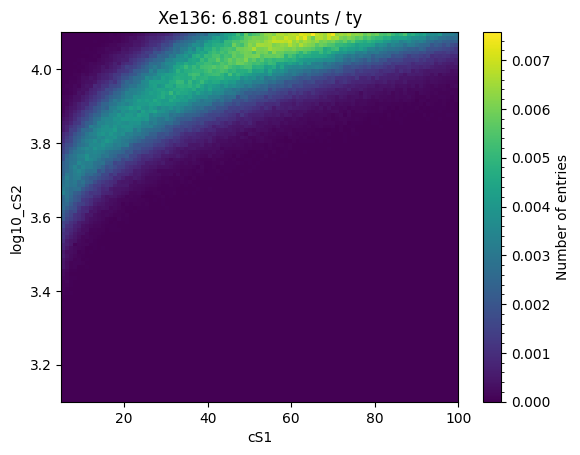

In [14]:
Xe136_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

Xe136_data = Xe136.simulate(int(1e7))

Xe136_hist.add(Xe136_data['cs1'], np.log10(Xe136_data['cs2']))

Xe136_mu = Xe136.estimate_mu(n_trials=int(1e7))
Xe136_hist.histogram = Xe136_hist.histogram / Xe136_hist.n * Xe136_mu

Xe136_hist.plot()
plt.title(f'Xe136: {Xe136_mu:.3f} counts / ty')

pdfs[0]['Xe136'] = Xe136_hist

In [15]:
Xe124 = fd.xlzd.XLZDXe124Source(configuration='60t',
                                drift_field_V_cm=drift_field_V_cm, gas_field_kV_cm=gas_field_kV_cm,
                                elife_ns=elife_ns, g1=g1)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


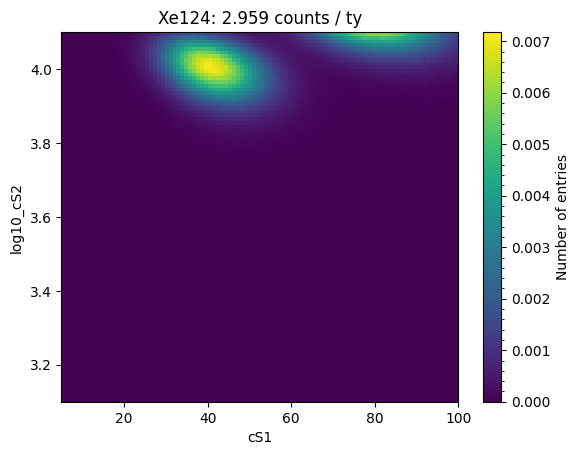

In [16]:
Xe124_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

Xe124_data = Xe124.simulate(int(1e7))

Xe124_hist.add(Xe124_data['cs1'], np.log10(Xe124_data['cs2']))

Xe124_mu = Xe124.estimate_mu(n_trials=int(1e7))
Xe124_hist.histogram = Xe124_hist.histogram / Xe124_hist.n * Xe124_mu

Xe124_hist.plot()
plt.title(f'Xe124: {Xe124_mu:.3f} counts / ty')

pdfs[0]['Xe124'] = Xe124_hist

In [17]:
neutrons = fd.xlzd.XLZDWIMPSource(wimp_mass=46,
                                  configuration='60t',
                                  drift_field_V_cm=drift_field_V_cm, gas_field_kV_cm=gas_field_kV_cm,
                                  elife_ns=elife_ns, g1=g1)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


Text(0.5, 1.0, 'Neutrons')

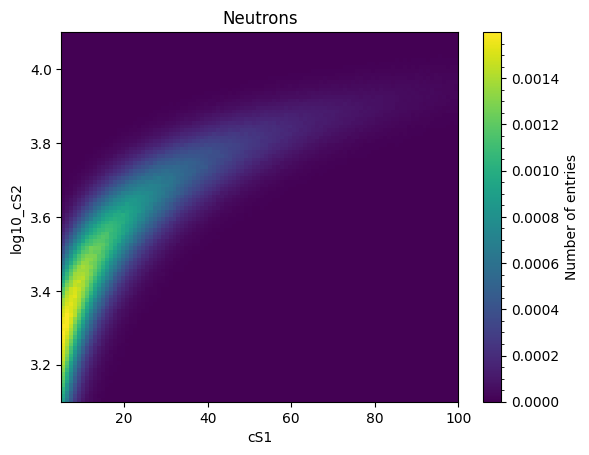

In [18]:
neutrons_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

neutrons_data = neutrons.simulate(int(1e7))

neutrons_hist.add(neutrons_data['cs1'], np.log10(neutrons_data['cs2']))

neutrons_hist.histogram = neutrons_hist.histogram / neutrons_hist.n

neutrons_hist.plot()
plt.title(f'Neutrons')

In [19]:
if (conditions == 'good'):
    pdfs[0]['neutrons_high_LNGS'] = neutrons_hist * 0.043
    pdfs[0]['neutrons_low_LNGS'] = neutrons_hist * (0.043 / 10.)
    pdfs[0]['neutrons_high_SURF'] = neutrons_hist * 0.056
    pdfs[0]['neutrons_low_SURF'] = neutrons_hist * (0.056 / 10.)

## Signal sources

In [20]:
CEvNS_other_LNGS = fd.xlzd.XLZDvNROtherLNGSSource(configuration='60t',
                                                  drift_field_V_cm=drift_field_V_cm, gas_field_kV_cm=gas_field_kV_cm,
                                                  elife_ns=elife_ns, g1=g1)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


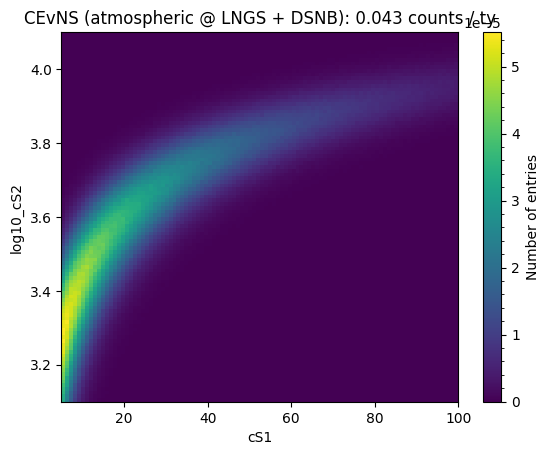

In [21]:
CEvNS_other_LNGS_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

CEvNS_other_LNGS_data = CEvNS_other_LNGS.simulate(int(1e7))

CEvNS_other_LNGS_hist.add(CEvNS_other_LNGS_data['cs1'], np.log10(CEvNS_other_LNGS_data['cs2']))

CEvNS_other_LNGS_mu = CEvNS_other_LNGS.estimate_mu(n_trials=int(1e7))
CEvNS_other_LNGS_hist.histogram = CEvNS_other_LNGS_hist.histogram / CEvNS_other_LNGS_hist.n * CEvNS_other_LNGS_mu

CEvNS_other_LNGS_hist.plot()
plt.title(f'CEvNS (atmospheric @ LNGS + DSNB): {CEvNS_other_LNGS_mu:.3f} counts / ty')

pdfs[1]['CEvNS_other_LNGS'] = CEvNS_other_LNGS_hist

In [22]:
CEvNS_other_SURF = fd.xlzd.XLZDvNROtherSURFSource(configuration='60t',
                                                  drift_field_V_cm=drift_field_V_cm, gas_field_kV_cm=gas_field_kV_cm,
                                                  elife_ns=elife_ns, g1=g1)

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/flamedisx/source.py:271: UserWarning: Defaults for unused settings ignored: {'configuration': '60t'}
  warnings.warn(f"Defaults for unused settings ignored: {unused}")


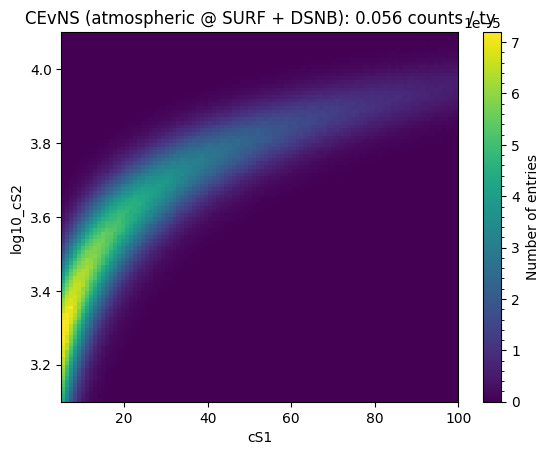

In [23]:
CEvNS_other_SURF_hist = Histdd(bins=100, range=[[cS1_min, cS1_max], [log10_cS2_min, log10_cS2_max]], axis_names=['cS1', 'log10_cS2'])

CEvNS_other_SURF_data = CEvNS_other_SURF.simulate(int(1e7))

CEvNS_other_SURF_hist.add(CEvNS_other_SURF_data['cs1'], np.log10(CEvNS_other_SURF_data['cs2']))

CEvNS_other_SURF_mu = CEvNS_other_SURF.estimate_mu(n_trials=int(1e7))
CEvNS_other_SURF_hist.histogram = CEvNS_other_SURF_hist.histogram / CEvNS_other_SURF_hist.n * CEvNS_other_SURF_mu

CEvNS_other_SURF_hist.plot()
plt.title(f'CEvNS (atmospheric @ SURF + DSNB): {CEvNS_other_SURF_mu:.3f} counts / ty')

pdfs[1]['CEvNS_other_SURF'] = CEvNS_other_SURF_hist

## Save all PDFs

In [24]:
if not os.path.exists('PDFs'):
    os.makedirs('PDFs')

In [25]:
pkl.dump(pdfs, open(f'PDFs/pdfs_CEvNS_disco_60t_{conditions}.pkl', 'wb'))

## ROC curve between CEvNS and SolarER

In [26]:
def hist_to_cdf(hist, ordering):
    return np.cumsum(hist.histogram.ravel()[ordering]) / hist.n

In [27]:
def ROC_2D(template_sig, template_bg):
    ratio = (template_bg + 1e-10) / (template_sig + 1e-10)
    ratio_ordering = np.argsort(ratio.histogram.ravel())

    roc = (hist_to_cdf(template_bg, ratio_ordering),
           hist_to_cdf(template_sig, ratio_ordering))

    return roc

Text(2.11163592664349e-07, 0.7, 'Background fraction @ 50% signal: 1.42e-03')

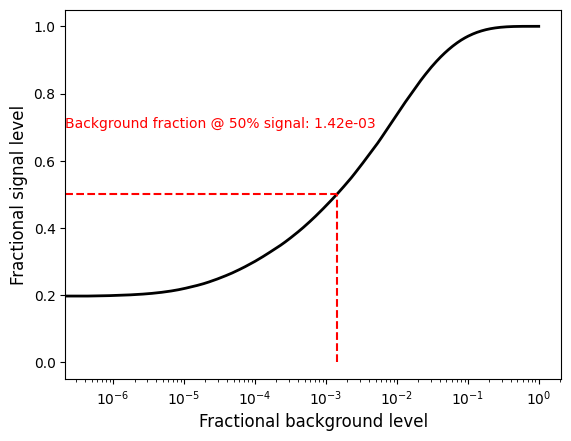

In [28]:
roc = ROC_2D(CEvNS_other_LNGS_hist, SolarER_hist)
bg_at_50_sig = np.interp(0.5, xp=roc[1], fp=roc[0])

plt.plot(*roc, linewidth=2, color='k')
plt.xscale('log')
plt.xlabel('Fractional background level', fontsize=12)
plt.ylabel('Fractional signal level', fontsize=12)
plt.hlines(0.5, 0., bg_at_50_sig, color='r', linestyle='--')
plt.vlines(bg_at_50_sig, 0., 0.5, color='r', linestyle='--')
plt.text(plt.gca().get_xlim()[0], 0.7, f'Background fraction @ 50% signal: {bg_at_50_sig:.2e}', color='r')